# Análise Exploratória — Qualidade da Água 

O notebook contém limpeza de dados, análises estatísticas e vários gráficos com foco em ETAs (estações) e nos analitos: Fluoride, pH, Total THMs, Chlorate, Chlorite.


In [2]:
# ======================================
# Importação de bibliotecas
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats 
import matplotlib.dates as mdates

# Configuração estética dos gráficos
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette(["#0B1B54", "#8594D4", "#FEC5B7", "#FF7655"])
plt.rcParams['figure.figsize'] = (10,6)

# ======================================
# Leitura do dataset
# ======================================
file_path = "dataset_water_trant.csv"  
df = pd.read_csv(file_path)

# Verificar primeiras linhas
df.head()


,date_sample,sample_source,sample_id,analyte,value_qualifier,analyte_value,value_units,source_description
0,2025-01-01,206 SYS,W1729476,Fluoride,NaN,0.776,MG/L,1055 Catalina Blvd @ Fire Station Sample Stanc...
1,2025-01-02,119 SYS,W1729381,pH,NaN,7.985,PH,Lower Otay Recreation
2,2025-01-02,251 SYS,W1729312,Fluoride,NaN,0.602,MG/L,5840 Ravenswood Rd.
3,2025-01-02,300 SYS,W1729331,Chlorate,NaN,156.000,UG/L,5368 Topsail Drive
4,2025-01-02,300 SYS,W1729331,Chlorite,NaN,326.000,UG/L,5368 Topsail Drive


## Séries temporais por analito

Variação da média ao longo do tempo, para cada analito.

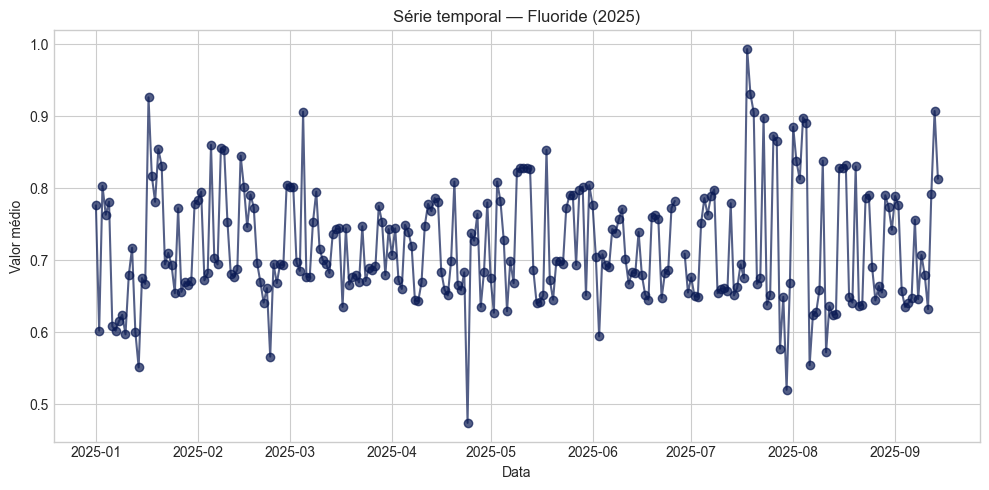

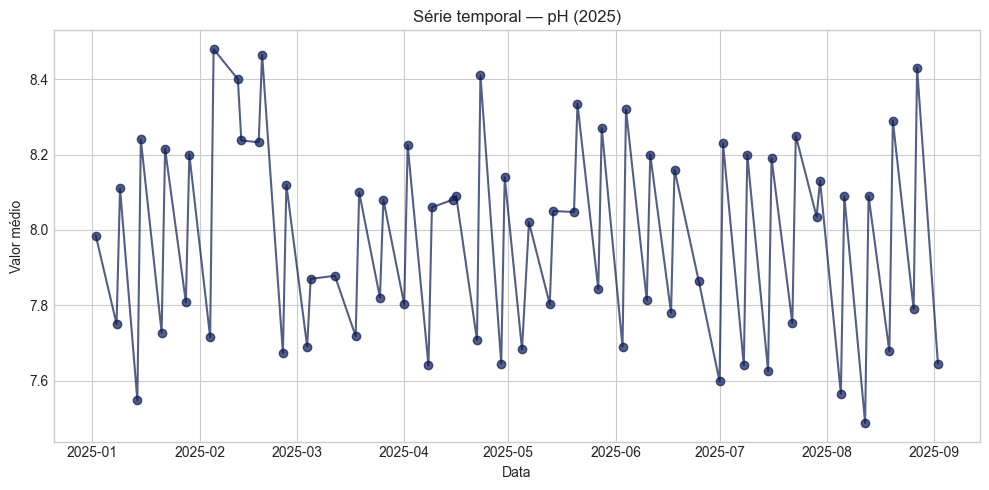

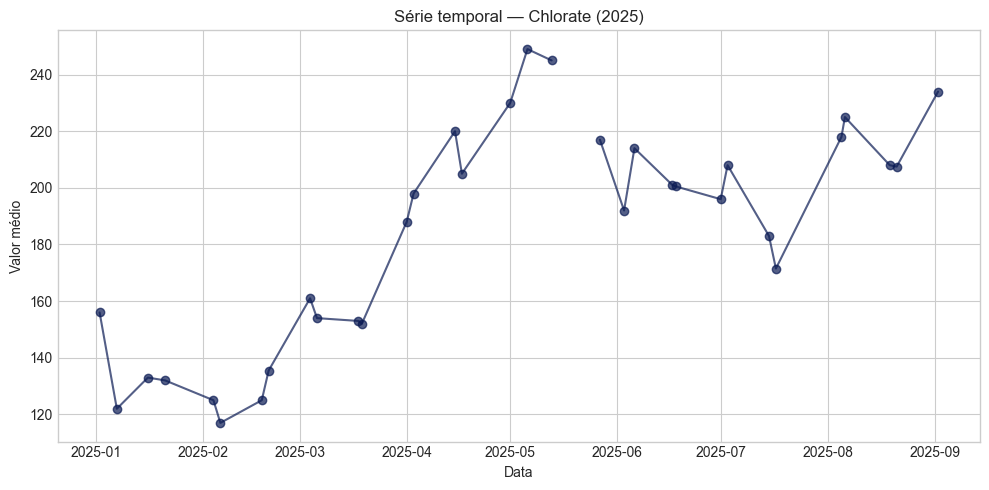

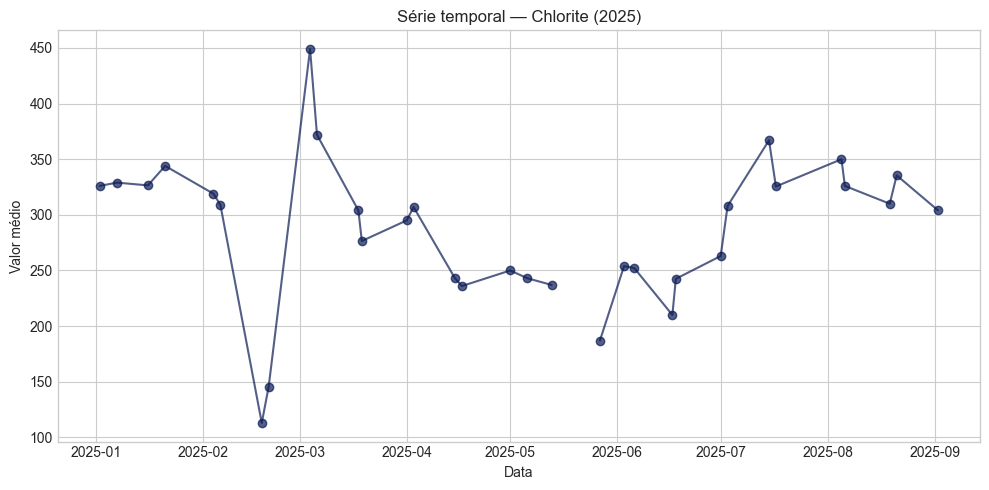

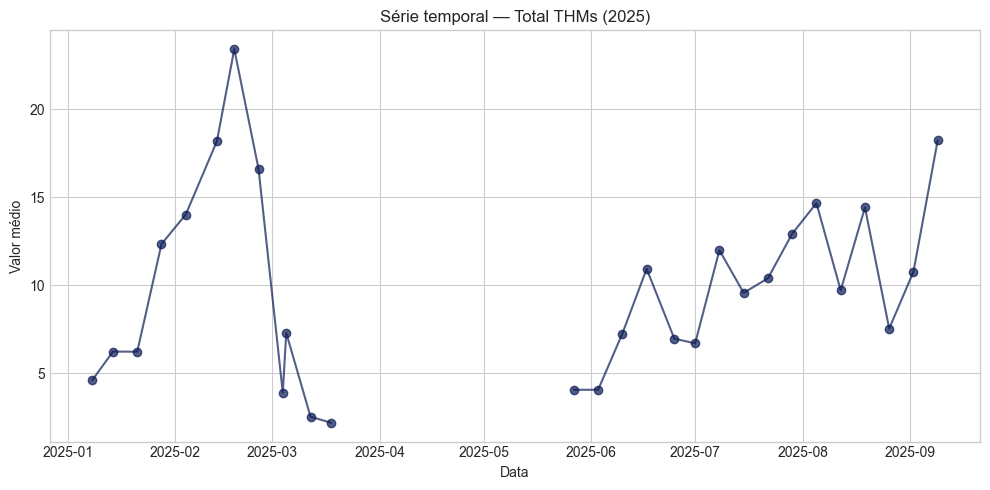

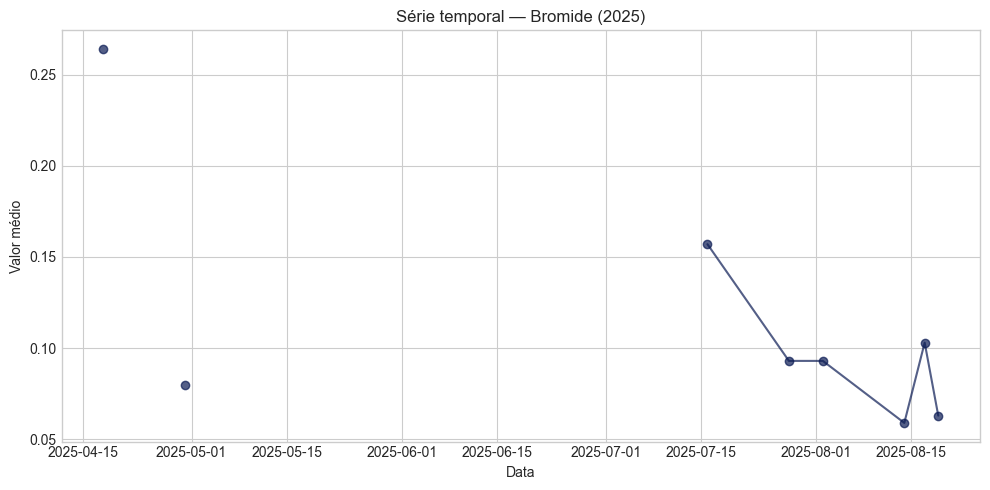

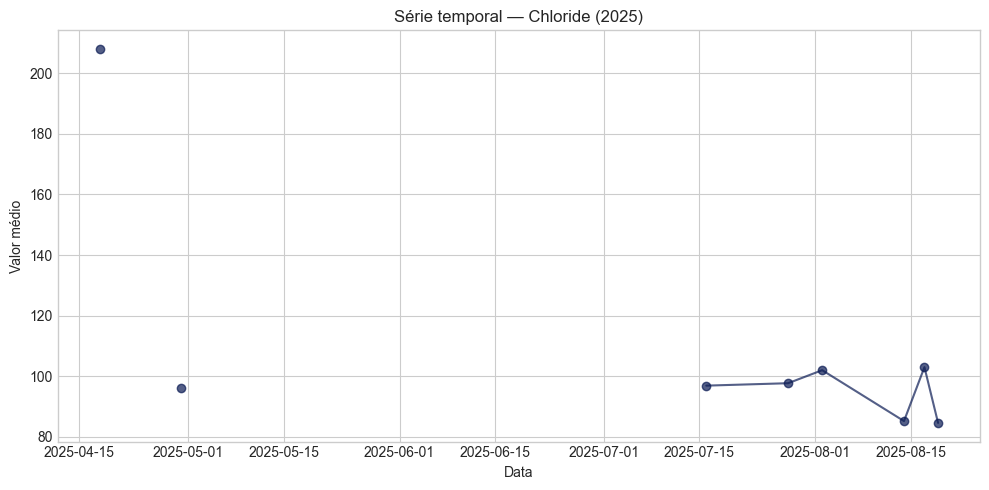

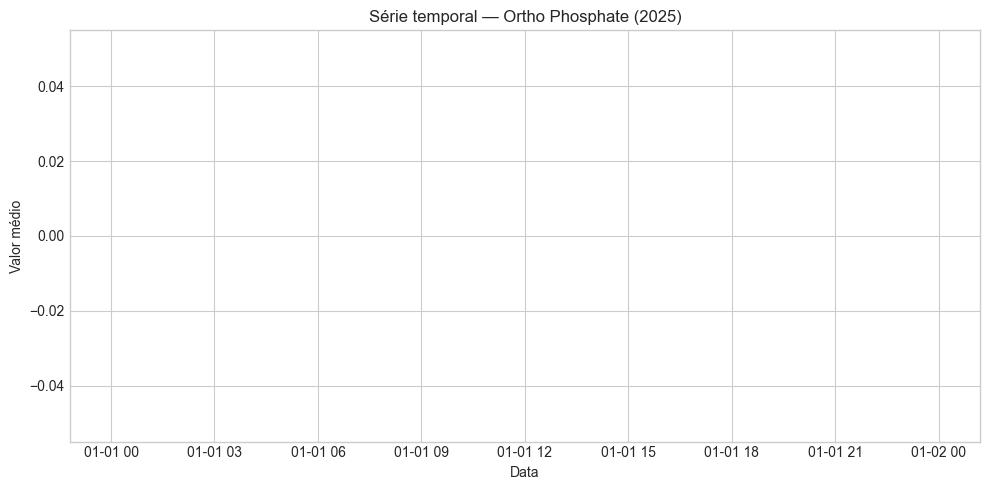

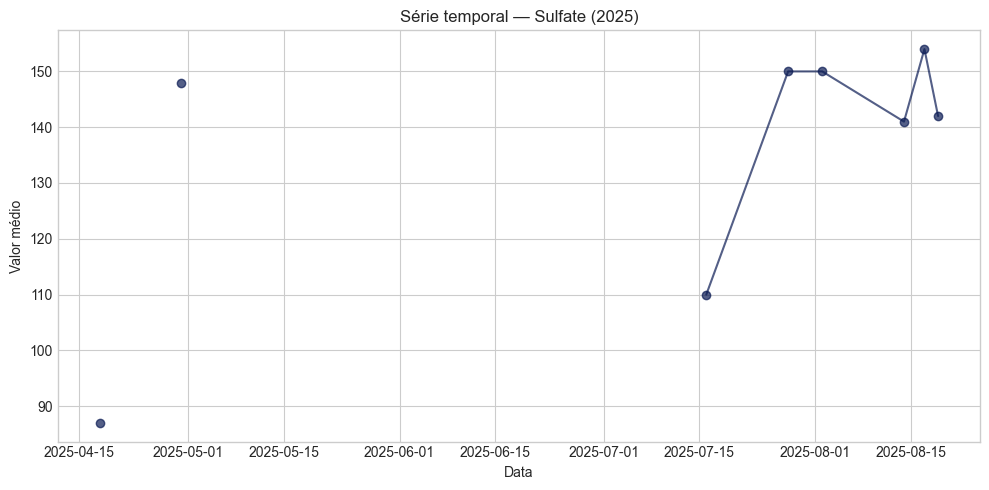

In [3]:
# ======================================
# Variação temporal dos analitos em 2025
# ======================================


# garantir que a coluna de data está no formato datetime
df['date_sample'] = pd.to_datetime(df['date_sample'], errors='coerce')

# filtrar só o ano de 2025
df_2025 = df[df['date_sample'].dt.year == 2025]

analytes = df_2025['analyte'].unique()

for analyte in analytes:
    sub = (
        df_2025[df_2025['analyte'] == analyte]
        .groupby('date_sample')['analyte_value']
        .mean()
    )
    
    plt.figure(figsize=(10,5))
    plt.plot(sub.index, sub.values, marker='o', alpha=0.7)
    plt.title(f"Série temporal — {analyte} (2025)")
    plt.xlabel("Data")
    plt.ylabel("Valor médio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Estatísticas gerais e contagens

Aqui calculamos estatísticas por analito.

In [4]:
# ======================================
# Estatísticas descritivas por analito
# ======================================

# Converter coluna para numérico 
df["analyte_value_num"] = pd.to_numeric(df["analyte_value"], errors="coerce")

# Estatísticas por analito
stats = df.groupby('analyte')['analyte_value_num'].agg(['count','min','median','mean','max']).reset_index()
stats
percentis = (
    df.groupby("analyte")["analyte_value_num"]
      .quantile([0.05,0.25,0.75,0.95])
      .unstack()
      .rename(columns={0.05:"p05",0.25:"q1",0.75:"q3",0.95:"p95"})
      .reset_index()
)

stats = stats.merge(percentis, on="analyte")
display(stats.head(20))


,analyte,count,min,median,mean,max,p05,q1,q3,p95
0,Bromate,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bromide,8,0.0590,0.09300,0.114000,0.2640,0.060400,0.075750,0.116500,0.226550
2,Calcium Hardness,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Chlorate,503,20.3000,188.00000,188.049006,598.0000,114.200000,157.000000,214.000000,276.850000
4,Chloride,13,84.6000,97.70000,110.173077,208.0000,84.960000,95.500000,103.000000,178.000000
5,Chlorite,482,34.0500,309.00000,308.496888,980.0000,103.100000,217.250000,383.000000,494.850000
6,Fluoride,3424,0.0940,0.60800,0.591337,1.1100,0.291300,0.523000,0.675000,0.812000
7,Nitrate,4,0.8330,1.49250,1.405750,1.8050,0.894050,1.138250,1.760000,1.796000
8,Nitrate (as N),4,0.1882,0.33715,0.317550,0.4077,0.201985,0.257125,0.397575,0.405675
9,Ortho Phosphate,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Série temporal — Fluoride

Plot da média diária de Fluoride, com média móvel e linha de tendência (regressão linear).

C:\Users\rafaellaantunes-ieg\AppData\Local\Temp\ipykernel_59856\1887394225.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = fluoride.groupby(pd.Grouper(key='date_sample', freq='M'))['analyte_value_num'].mean().reset_index()


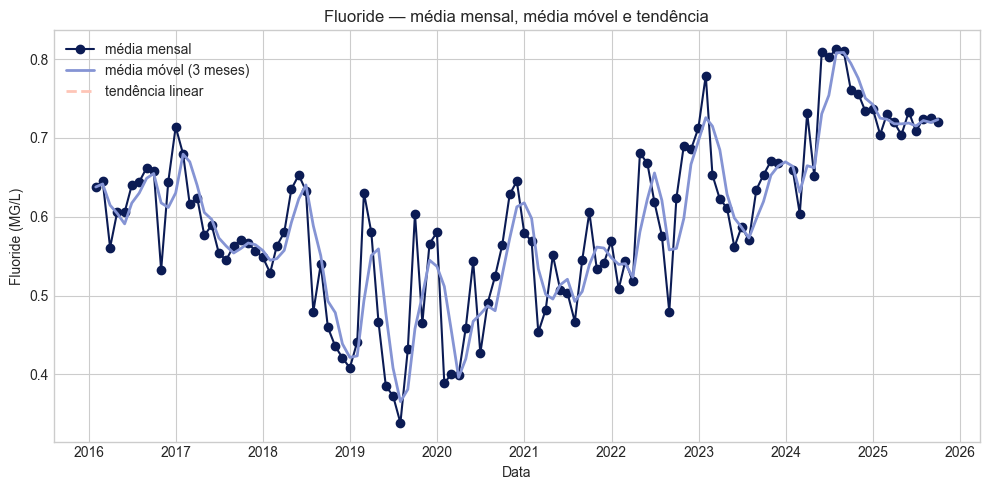

In [ ]:

from scipy import stats  # não sei porque ele se recusa a pegar a importação la de cima

# ======================================
# Análise de tendência para Fluoride
# ======================================

# Converter para datetime
df['date_sample'] = pd.to_datetime(df['date_sample'], errors='coerce')

fluoride = df[df['analyte'] == 'Fluoride'].copy()

# Média mensal em vez de diária
monthly = fluoride.groupby(pd.Grouper(key='date_sample', freq='M'))['analyte_value_num'].mean().reset_index()

# Rolling de 3 meses
monthly['rolling3'] = monthly['analyte_value_num'].rolling(window=3, min_periods=1).mean()

# Regressão linear com base no índice (tempo)
x = np.arange(len(monthly))
slope, intercept, r, p, se = stats.linregress(x, monthly['analyte_value_num'])  

plt.figure(figsize=(10,5))
plt.plot(monthly['date_sample'], monthly['analyte_value_num'], marker='o', label='média mensal')
plt.plot(monthly['date_sample'], monthly['rolling3'], label='média móvel (3 meses)', linewidth=2)
plt.plot(monthly['date_sample'], intercept + slope*x, '--', label='tendência linear', linewidth=2)

plt.title('Fluoride — média mensal, média móvel e tendência')
plt.xlabel('Data')
plt.ylabel('Fluoride (MG/L)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




## Correlações entre analitos (quando presentes na mesma amostra)

Construímos uma matriz de correlação usando a tabela 'wide'.

Matriz de correlação (Pearson):
analyte     Fluoride        pH  Total THMs  Chlorate  Chlorite
analyte                                                       
Fluoride    1.000000  0.056174   -0.039363  0.035100  0.121730
pH          0.056174  1.000000   -0.039275 -0.309991 -0.086882
Total THMs -0.039363 -0.039275    1.000000 -0.173917 -0.440488
Chlorate    0.035100 -0.309991   -0.173917  1.000000  0.155608
Chlorite    0.121730 -0.086882   -0.440488  0.155608  1.000000


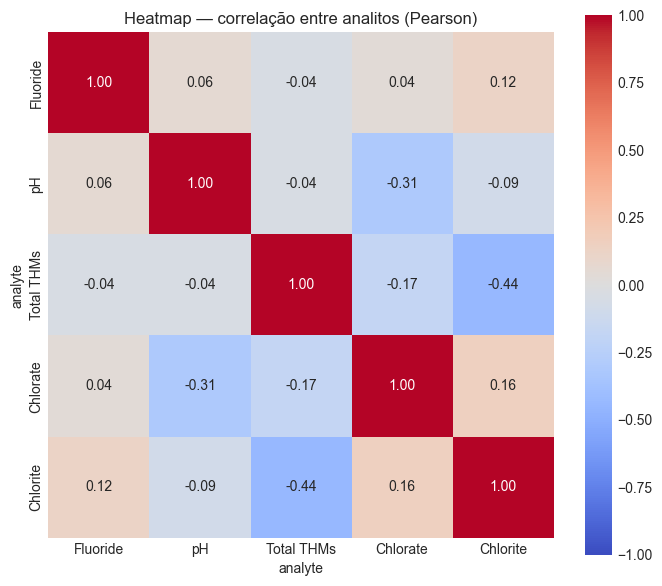

In [ ]:
# ======================================
# Correlação entre analitos
# ======================================


# Converter para formato wide: cada analito vira uma coluna
wide = df.pivot_table(
    index='date_sample',       # datas como índice
    columns='analyte',         # analitos como colunas
    values='analyte_value_num' # valores numéricos
).reset_index()

#Calculo de correlação
analitos = ['Fluoride','pH','Total THMs','Chlorate','Chlorite']
corr_df = wide[analitos].corr()
print('Matriz de correlação (Pearson):')
print(corr_df)

# Heatmap com seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Heatmap — correlação entre analitos (Pearson)')
plt.tight_layout()
plt.show()


## Análise de Correlação entre Chlorate e Chlorite nos anos 2024 e 2025

Filtramos dados de 2024 e 2025 para Chlorate e Chlorite, calculando a correlação de Pearson e observamos a dispersão com linha de tendência para comparar os dois compostos.

analyte date_sample sample_source sample_id  Chlorate  Chlorite
2        2024-01-16       284 SYS  W1629243     132.0     354.0
3        2024-01-18       300 SYS  W1629443     129.0     330.0
4        2024-01-18      204A SYS  W1629444     114.0     362.0
5        2024-01-31       300 SYS  W1632499     145.0     336.0
6        2024-02-06       284 SYS  W1634020     163.0     423.0
Correlação de Pearson: r=0.0862, p=0.4013


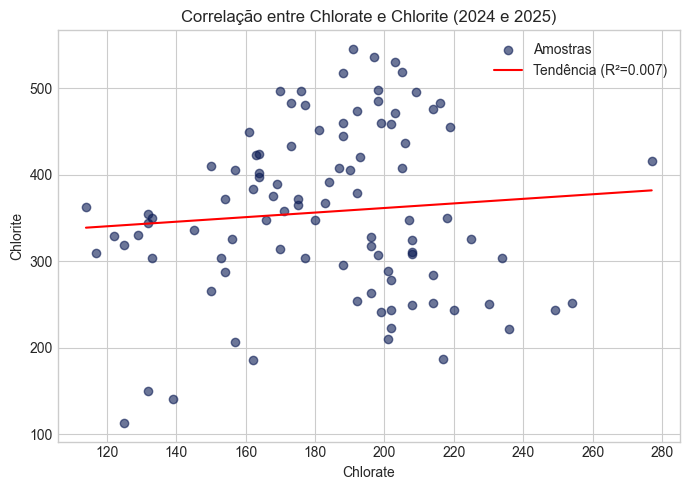

In [ ]:
# ======================================
# Análise detalhada: Chlorate vs Chlorite
# ======================================


from scipy import stats 
import matplotlib.dates as mdates # Por algum motivo ele não funciona se os imports n tiverem na celula (Mesmo eu ja tendo importado antes) então eu só aceitei deixar assim

# Garantir que a coluna de datas está em formato datetime
df['date_sample'] = pd.to_datetime(df['date_sample'])

# Filtrar apenas os dados referentes aos anos 2024 e 2025
df_filtered = df[df['date_sample'].dt.year.isin([2024, 2025])]

# Pivotar os dados para colocar Chlorate e Chlorite como colunas separadas
pairs = (
    df_filtered[df_filtered['analyte'].isin(['Chlorate','Chlorite'])]  # Seleciona apenas Chlorate e Chlorite
    .pivot_table(
        index=['date_sample','sample_source','sample_id'],  # Mantém essas colunas como índices
        columns='analyte',  # Converte os valores de analyte em colunas separadas
        values='analyte_value',  # Valores preenchidos a partir de analyte_value
        aggfunc='first'  # Se houver duplicatas, mantém o primeiro valor
    )
    .reset_index()  # Transforma índices em colunas
)

# Remover linhas onde Chlorate ou Chlorite estão faltando
pairs = pairs.dropna(subset=['Chlorate','Chlorite'])

# Mostrar as primeiras linhas do DataFrame resultante
print(pairs.head())

#Cálculo da Correlação de Pearson
pearson_r, pearson_p = stats.pearsonr(pairs['Chlorate'], pairs['Chlorite'])
print(f"Correlação de Pearson: r={pearson_r:.4f}, p={pearson_p:.4g}")

#Plotagem do Scatterplot com Linha de Tendência
plt.figure(figsize=(7,5))
plt.scatter(pairs['Chlorate'], pairs['Chlorite'], alpha=0.6, label='Amostras')  # Pontos do gráfico

# Cálculo da linha de regressão linear
slope, intercept, r, p, se = stats.linregress(pairs['Chlorate'], pairs['Chlorite'])
x_vals = np.linspace(pairs['Chlorate'].min(), pairs['Chlorate'].max(), 100)  # Valores x para linha
plt.plot(x_vals, intercept + slope*x_vals, color='red', label=f'Tendência (R²={r**2:.3f})')  # Linha de tendência

# Adicionar labels, título e legenda
plt.xlabel('Chlorate')
plt.ylabel('Chlorite')
plt.title('Correlação entre Chlorate e Chlorite (2024 e 2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Média Semanal de Total THMs desde 2021

Média semanal dos valores de Total THMs (Tri-Halometanos), considerando apenas registros a partir de 2021

C:\Users\rafaellaantunes-ieg\AppData\Local\Temp\ipykernel_59856\959735879.py:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rafaellaantunes-ieg\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


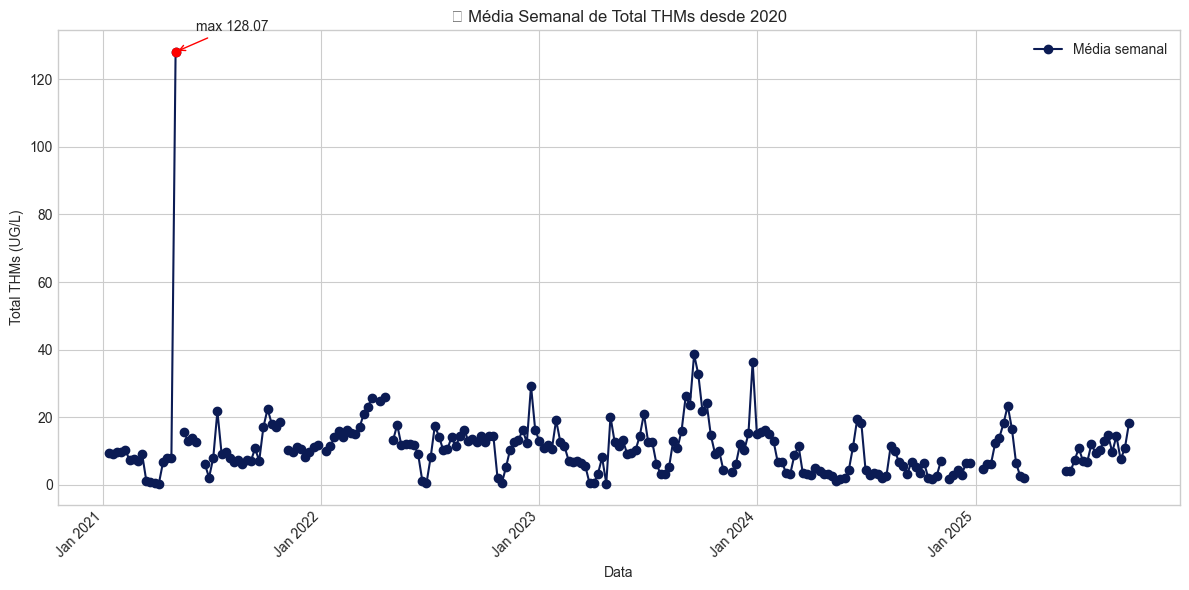

In [11]:
# ======================================
# Média semanal de Total THMs desde 2021
# ======================================

# Garantir que a coluna de datas está em formato datetime
df['date_sample'] = pd.to_datetime(df['date_sample'], errors='coerce')

# Converter a coluna analyte_value para numérico
df['analyte_value_num'] = pd.to_numeric(df['analyte_value'], errors='coerce')

# Filtrar apenas os dados de "Total THMs" a partir de 2021
thms = df[
    (df['analyte'] == 'Total THMs') &
    (df['date_sample'] >= pd.to_datetime("2021-01-01"))
].copy()

if not thms.empty:
    # Agrupar por semana e calcular a média dos valores
    thms_daily = (
        thms.groupby(pd.Grouper(key='date_sample', freq='W'))['analyte_value_num']
        .mean()  # Média semanal
        .reset_index()  # Voltar indices para colunas
        .sort_values('date_sample')  # Ordenar por data
    )

    # Criar figura do gráfico
    plt.figure(figsize=(12,6))

    # Plotar linha da média semanal
    plt.plot(
        thms_daily['date_sample'],
        thms_daily['analyte_value_num'],
        marker='o',
        linestyle='-',
        label='Média semanal'
    )

    # Identificar e marcar o valor máximo no gráfico
    idx_max = thms_daily['analyte_value_num'].idxmax()
    vmax = thms_daily.loc[idx_max]
    plt.scatter(vmax['date_sample'], vmax['analyte_value_num'], color='red', zorder=5)
    plt.annotate(
        f"max {vmax['analyte_value_num']:.2f}",
        (vmax['date_sample'], vmax['analyte_value_num']),
        xytext=(15,15),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='red')
    )

    # Ajustar eixo X para melhor legibilidade
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha='right')

    # Adicionar título e rótulos
    plt.title('📊 Média Semanal de Total THMs desde 2020')
    plt.xlabel('Data')
    plt.ylabel('Total THMs (UG/L)')

    # Adicionar grade e legenda
    plt.grid(True)
    plt.tight_layout()
    plt.legend()

    # Mostrar gráfico
    plt.show()

else:
    print('Não há registros suficientes de Total THMs desde 2020.')


## Sumário de dados faltantes e cobertura por analito/ETA

In [ ]:
# ======================================
# Percentual de cobertura por analito
# ======================================

# Percentual de cobertura por analito
coverage = df.groupby('analyte').size().reset_index(name='count')
total = len(df)
coverage['pct'] = 100 * coverage['count'] / total
coverage

,analyte,count,pct
0,Bromate,10,0.111495
1,Bromide,96,1.070353
2,Calcium Hardness,1,0.011150
3,Chlorate,536,5.976140
4,Chloride,96,1.070353
5,Chlorite,530,5.909243
6,Fluoride,3504,39.067901
7,Nitrate,4,0.044598
8,Nitrate (as N),4,0.044598
9,Ortho Phosphate,88,0.981157
